In [1]:
%pylab inline
import bacco

import os
import imp
import time

import scipy.stats

import bacco.probabilistic_bias as pb
from bacco.decorators import h5cache
import copy

Populating the interactive namespace from numpy and matplotlib


ModuleNotFoundError: No module named 'bacco'

In [2]:
t = 26
sim = bacco.Simulation(basedir="/cosmos_storage/cosmosims/Rings_Simulations/TheOne_N4320_L1440/3.14", 
                       halo_file="groups_%03d/fof_subhalo_history_tab_orph_wweight_%03d" % (t,t))

2024-08-07 20:04:25,269 bacco.sims : Initialising simulation Default
2024-08-07 20:04:25,271 bacco.sims : try /cosmos_storage/cosmosims/Rings_Simulations/TheOne_N4320_L1440/3.14/groups_026/fof_subhalo_history_tab_orph_wweight_026
2024-08-07 20:04:25,275 bacco.sims : Loading /cosmos_storage/cosmosims/Rings_Simulations/TheOne_N4320_L1440/3.14/groups_026/fof_subhalo_history_tab_orph_wweight_026
2024-08-07 20:04:25,286 bacco.cosmo :    initialization took 0.000 secs
2024-08-07 20:04:25,350 bacco.sims : ...done in 0.0181 s


In [3]:
%%time
cachedir="/scratch/stuecker/data/cache/eulerian_test"
#pbm = pb.ProbabilisticBiasManager(sim, ngrid="sdm8", damping_scale=0.75, variables=("J2","J4"), verbose=1, cachedir=cachedir)
print('instancenado clase')
pbm = pb.ProbabilisticBiasManager(sim, ngrid="sdm8", damping_scale=0.25, variables=("J2","J4"), verbose=1)#, cachedir=cachedir)


# galaxy sample
print('reading galaxy sample')
qgal = np.load("/scratch/stuecker/data/bias_mock/input/SHAMe_RedSample_TheOne_N4320_L1440_3.14_z0.9_n0.002_qgal.npy")

# select galaxies by density
print('selecting galaxies')
vpeak = np.load("/scratch/stuecker/data/bias_mock/galvpeak_RedSample.npy")
ndens = 5e-04
vsel = np.percentile(vpeak, 100.*(1.-ndens/2e-3))
sel = vpeak >= vsel

print('fit parameters')
model_exp2 = pbm.setup_bias_model(bias_class=pb.TensorBiasND, terms=("J2", "J22", "J4"), spatial_order=4)
#model_exp2 = pbm.setup_bias_model(bias_class=pb.TensorBiasND, terms=("delta", "laplacian"), spatial_order=4)
print('fiting model')
pbm.fit_bias(model = model_exp2, tracer_q = qgal[sel])
origin_model = pbm.eulerian_tracer_density(model=model_exp2)

print('bias parameters:',model_exp2.par)

instancenado clase
reading galaxy sample
selecting galaxies
fit parameters


2024-08-07 20:04:25,861 bacco.cosmo :    computed CAMB power spectrum at z=0.00 in 0.138 secs
2024-08-07 20:04:25,875 bacco.cosmo :    created Pk(z=0) tab from k 7.37789596314542e-05 to 100000.0 h/Mpc


Linear Fields 76.315
fiting model
Tracers Q 0.002


2024-08-07 20:05:44,380 bacco.sims : Reconstructing sDM


Tracers Value 2.198
Tracers Mask 0.045
Define Tracers 2.252


2024-08-07 20:05:46,418 bacco.sims : Reading 808779834 items for sDM/ih_pos
2024-08-07 20:06:10,004 bacco.sims : Reading 357996815 items for GroupPos
2024-08-07 20:06:29,370 bacco.sims : Reading 808779834 items for sDM/ih_vel
2024-08-07 20:06:50,259 bacco.sims : Reading 357996815 items for GroupVel
2024-08-07 20:07:06,121 bacco.sims : Reading 808779834 items for sDM/offset
2024-08-07 20:07:48,260 bacco.sims : Reading 808779834 items for sDM/pos
2024-08-07 20:08:31,263 bacco.sims : Reading 808779834 items for sDM/vel
2024-08-07 20:09:15,773 bacco.sims : Reading 808779834 items for sDM/ih_ids
2024-08-07 20:09:34,571 bacco.sims : Reading 808779834 items for sDM/ids
2024-08-07 20:10:11,964 bacco.sims : Done reconstructing sDM


Read particle positions 267.586
Lagrangian sorting of particle positions 329.873


2024-08-07 20:15:49,111 bacco.statistics : Computing cic mesh with ngrid=540 and interlacing=False
2024-08-07 20:15:49,625 bacco.statistics : starting deposit 1
2024-08-07 20:15:50,389 bacco.statistics :  mesh done in 1.28 s


bias parameters: [ 0.98627658  0.04201587 -5.56445679]
CPU times: user 9min 35s, sys: 3min 6s, total: 12min 42s
Wall time: 11min 26s


In [5]:
# transformo el modelo final de density a overdensity
rho_exp = origin_model[:,:,:][0]/np.mean(origin_model[:,:,:][0]) - 1

In [6]:
# obtengo los parametros fiteados por el modelo

b1 = model_exp2.par[0]
b2 = model_exp2.par[1]
b4 = model_exp2.par[2]

print(b1,b2,b4)

0.9862765790293998 0.04201587322843152 -5.564456793219657


In [ ]:
#model_exp2 = pbm.setup_bias_model(bias_class=pb.TensorBiasND, terms=("J2", "J22", "J4"), spatial_order=4)
#pbm.fit_bias(model = model_exp2, tracer_q = qgal[sel])
#print(model_exp2.par)
#origin_model = pbm.eulerian_tracer_density(model=model_exp2)[0]

In [7]:
modelodeep = copy.deepcopy(model_exp2)

In [8]:
modelo_dm        = modelodeep
modelodeep = copy.deepcopy(modelodeep)
print(modelodeep.par)
modelo_dm.update_par([0.,0.,0.])
F0 = pbm.eulerian_tracer_density(model=modelo_dm)

modelo_dm        = modelodeep
modelodeep = copy.deepcopy(modelodeep)
modelo_dm.update_par([1.,0.,0.])
F1 = pbm.eulerian_tracer_density(model=modelo_dm) - F0

modelo_dm2        = modelodeep
modelodeep = copy.deepcopy(modelodeep)
print(modelodeep.par)
modelo_dm2.update_par([0.,1.,0.])
F2 = pbm.eulerian_tracer_density(model=modelo_dm2) - F0

modelo_laplacian        = modelodeep
modelodeep = copy.deepcopy(modelodeep)
print(modelodeep.par)
modelo_laplacian.update_par([0.,0.,1.])
F4 = pbm.eulerian_tracer_density(model=modelo_laplacian) - F0

[ 0.98627658  0.04201587 -5.56445679]
Read particle positions 0.000
Lagrangian sorting of particle positions 324.925


2024-08-07 20:26:26,044 bacco.statistics : Computing cic mesh with ngrid=540 and interlacing=False
2024-08-07 20:26:26,494 bacco.statistics : starting deposit 1
2024-08-07 20:26:27,235 bacco.statistics :  mesh done in 1.19 s


Read particle positions 0.000
Lagrangian sorting of particle positions 311.759


2024-08-07 20:31:47,424 bacco.statistics : Computing cic mesh with ngrid=540 and interlacing=False
2024-08-07 20:31:47,863 bacco.statistics : starting deposit 1
2024-08-07 20:31:48,593 bacco.statistics :  mesh done in 1.17 s


[ 0.98627658  0.04201587 -5.56445679]
Read particle positions 0.000
Lagrangian sorting of particle positions 309.555


2024-08-07 20:37:07,165 bacco.statistics : Computing cic mesh with ngrid=540 and interlacing=False
2024-08-07 20:37:07,605 bacco.statistics : starting deposit 1
2024-08-07 20:37:08,394 bacco.statistics :  mesh done in 1.23 s


[ 0.98627658  0.04201587 -5.56445679]
Read particle positions 0.000
Lagrangian sorting of particle positions 311.509


2024-08-07 20:42:28,504 bacco.statistics : Computing cic mesh with ngrid=540 and interlacing=False
2024-08-07 20:42:28,949 bacco.statistics : starting deposit 1
2024-08-07 20:42:29,679 bacco.statistics :  mesh done in 1.17 s


In [9]:
new_model = F0[0] + b1*F1[0] + b2*F2[0] + b4*F4[0]

In [10]:
rho_mean = np.mean(new_model)
delta_new = new_model/np.mean(new_model) - 1

In [11]:
np.save('F0.npy', F0[0]/rho_mean)
np.save('F1.npy', F1[0]/rho_mean)
np.save('F2.npy', F2[0]/rho_mean)
np.save('F4.npy', F4[0]/rho_mean)
np.save('modelo.npy',delta_new)

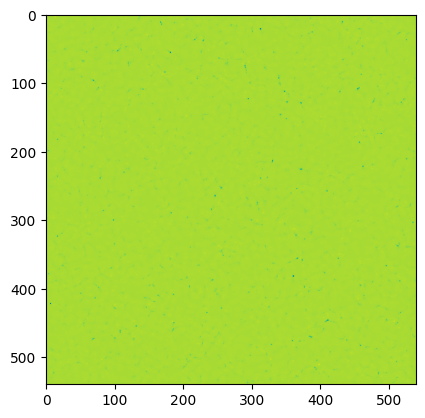

In [15]:
plt.imshow(F4[0][0,:,:])